# Double pendulum simulation

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils_dp import DoublePendulum
from utils_dp import calc_double_E, verification



L1, L2 = 1, 1
M1, M2 = 1, 5
F1, F2 = 0.001, 0.001

# L1, L2 = 3, 1.5
# M1, M2 = 1, 3
# F1, F2 = 0.01, 0.005

# init_theta1, init_omega1 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
# init_theta2, init_omega2 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
init_theta1, init_omega1 = 0.4725, 0.0
init_theta2, init_omega2 = 0.3449, 0.0

#### Fast damping
# init_theta1, init_omega1 = -1.317105, 0.0
# init_theta2, init_omega2 = 1.349789, 0.0
#### Slow damping
# init_theta1, init_omega1 = 1.1365, 0.0
# init_theta2, init_omega2 = 0.2636, 0.0

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)
tmax, dt = 3000, 0.005
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
# V, T, E = calc_double_E(y, **dp_params)

print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))


subsampling = True

if subsampling:
    #### Fine dt for generation and subsample for learning
    sampling_step = 20    # sample a row for every the step.
    sampling_dt = dt*sampling_step
    sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
    sampling_t = t[sampling_ind]
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y[sampling_ind]
    
#     scaled_y = scaled_y[sampling_ind]
#     input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
#     X = input_output_y
    ####
else:
    sampling_dt = dt
    sampling_t = t
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y
    

    
V, T, E = calc_double_E(X, **dp_params)
    
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.472500(27.072256),0.344900(19.761314)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)


Text(0, 0.5, 'Velocity (rad/s)')

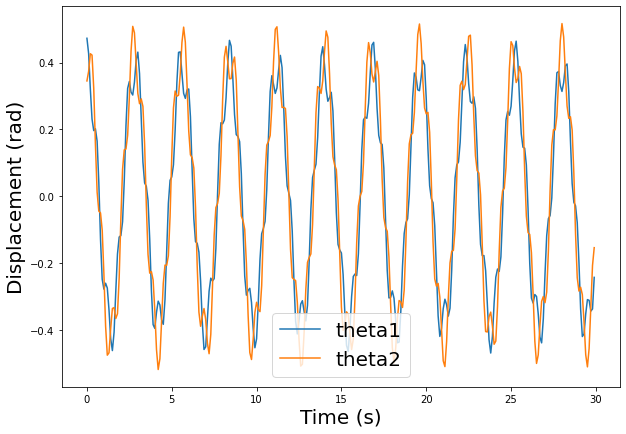

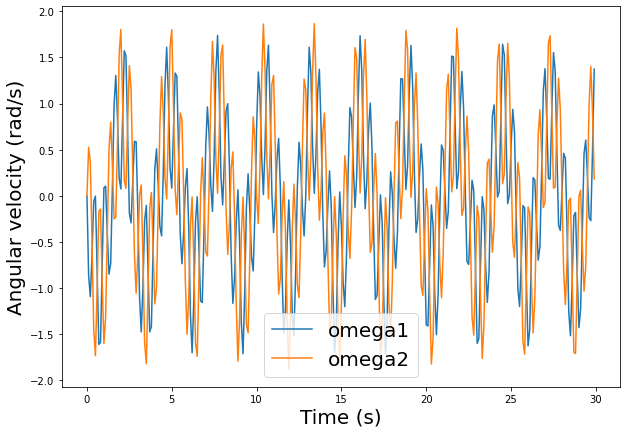

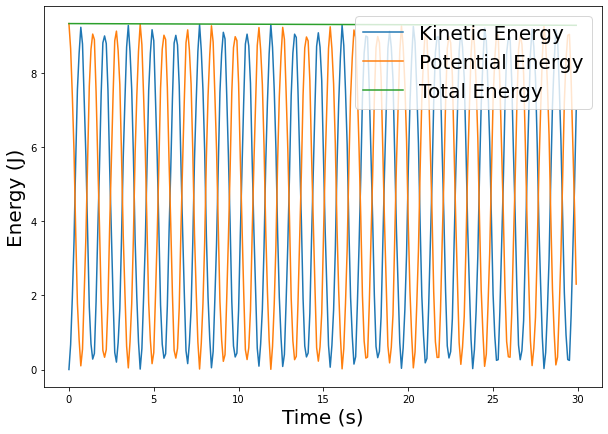

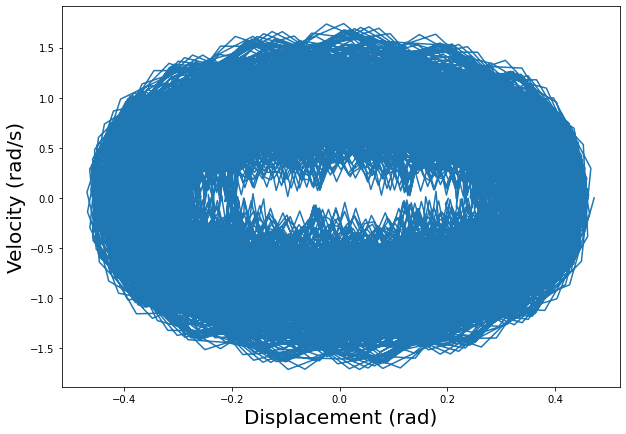

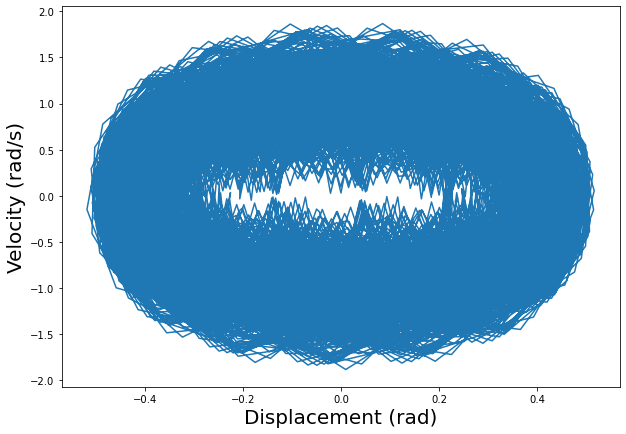

In [4]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = X[:,0], X[:,2]
omega1, omega2 = X[:,1], X[:,3]

min_ind, max_ind = 0, len(X)//100
plt.figure(0, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], theta1[min_ind:max_ind], label='theta1')
plt.plot(sampling_t[min_ind:max_ind], theta2[min_ind:max_ind], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], omega1[min_ind:max_ind], label='omega1')
plt.plot(sampling_t[min_ind:max_ind], omega2[min_ind:max_ind], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], T[min_ind:max_ind], label='Kinetic Energy')
plt.plot(sampling_t[min_ind:max_ind], V[min_ind:max_ind], label='Potential Energy')
plt.plot(sampling_t[min_ind:max_ind], E[min_ind:max_ind], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

In [ ]:
'''
Build an animation
'''
import matplotlib.animation as animation
from IPython.display import HTML

# Unpack z and theta as a function of time
theta1, theta2 = X[:,0], X[:,2]

# Convert to Cartesian coordinates of the two bob positions.
x1 = dp.L1 * np.sin(theta1)
y1 = -dp.L1 * np.cos(theta1)
x2 = x1 + dp.L2 * np.sin(theta2)
y2 = y1 - dp.L2 * np.cos(theta2)


fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, xlim=(-2, 2), ylim=(-L1-L2, 1))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2, c='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# initialization animation function: plot the background of each frame

def animate(i):
    line.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    time_text.set_text(time_template % (i*sampling_dt))
    return line, time_text

anim = animation.FuncAnimation(fig, animate, frames=1000, interval=sampling_dt*1000, blit=True)
HTML(anim.to_html5_video())

In [ ]:
'''
Generate a sequence of frames. It is for generating a gif file.
'''
fps = 10
di = int(1/fps/dt)*2

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, t.size, di):
    print(i // di, '/', t.size // di)
    dp.make_plot(i, ax)

## Learning a model for the prediction task
- Input: `X(t) (position, velocity)` of two objects
- Output: `X(t+1)`

In [5]:
'''
Data preprocessing for NN
'''
import random
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset





X = torch.tensor(X, dtype=torch.float32, device=device)
# static_X = torch.tensor([[L1,L2,M1,M2,F1,F2]], device=device)    # (L1,L2,M1,M2,F1,F2)

num_samples = X.shape[0]
# static_input_dim = static_X.shape[1]    # (L1,L2,M1,M2,F1,F2)
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 18000/3000/9000


In [113]:
from torch.distributions.beta import Beta
from model import RuleEncoder, DataEncoder, Net, NaiveModel

ret_dict = dict()
model_info = {'ours-test': {'rule': 0.0, 'beta': [0.1], 'scale': 100},
              'dataonly': {'rule': 0.0}
             }

for model_type in ['ours-test']:

    if model_type not in model_info:
        lr = 0.001
        rule_coeff = 0.0
        pert_coeff = 0.1
        scale = 1.0
        beta_param = [1.0]
        alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        model_params = {}

    else:
        model_params = model_info[model_type]
        lr = model_params['lr'] if 'lr' in model_params else 0.001
        rule_coeff = model_params['rule'] if 'rule' in model_params else 0.0
        pert_coeff = model_params['pert'] if 'pert' in model_params else 0.1
        scale = model_params['scale'] if 'scale' in model_params else 1.0
        beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
        if len(beta_param) == 1:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        elif len(beta_param) == 2:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))

    print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}\trule_coeff: {}\t scale: {}'.format(model_type, scale, beta_param, lr, rule_coeff, scale))

    ret_dict[model_type] = {}

    for seed in range(0,1):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        lr = 0.001
        SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
        if model_type == 'dataonly':
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        print('model_type:{}\t merge:{}, seed {} started.'.format(model_type, merge, seed))

        output_dim_encoder = 64
        hidden_dim_encoder = 64
        hidden_dim_db = 64
        output_dim = 4
        n_layers = 4

        rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)

        if merge == 'add':
            model = Net(output_dim_encoder, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)    # delta value prediction
        else:
            model = Net(output_dim_encoder*2, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)    # delta value prediction

        rule_weight = torch.tensor(model.rule_encoder.net[0].weight)
        data_weight = torch.tensor(model.data_encoder.net[0].weight)

        total_params = sum(p.numel() for p in model.parameters())
        print("total parameters: {}".format(total_params))

        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
        # loss_task = nn.MSELoss()
        l1_func = nn.L1Loss()
        best_val_loss = float('inf')
        optimizer = optim.Adam(model.parameters(), lr=lr)

        epochs = 1000
        early_stopping_thld = 10
        counter_early_stopping = 1
        log_interval = 500
        valid_freq = 5
        if SKIP:
            saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                                .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
        else:
            saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-no-skip.pt' \
                                .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2)
        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))

        # Training
        for epoch in range(1, epochs+1):
            model.train()
            for batch_idx, batch_data in enumerate(train_loader):
                batch_train_x = batch_data[0]
                batch_train_y = batch_data[1]

                optimizer.zero_grad()

                if model_type.startswith('dataonly'):
                    alpha = 0.0
                elif model_type.startswith('ruleonly'):
                    alpha = 1.0
                elif model_type.startswith('ours'):
                    alpha = alpha_distribution.sample().item()

                output = model(batch_train_x, alpha=alpha, merge=merge)    # only rule if alpha=1.    \hat{X}_{t+1}

                _, _, curr_E = calc_double_E(batch_train_x, **dp_params)    # E(X_t)    Energy of X_t (Current energy)
                _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
                _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

                loss_task = loss_task_func(output, batch_train_y)    # state prediction
                loss_rule = loss_rule_func(pred_E, curr_E)    # energy damping by friction: E_{t+1}<=E_t
                loss_mae = l1_func(output, batch_train_y).item()

                loss = alpha * loss_rule + scale * (1-alpha) * loss_task
                loss.backward()
                optimizer.step()


            # Evaluate on validation set
            if epoch % valid_freq == 0:
                model.eval()
                with torch.no_grad():
                    val_loss_task = 0
                    val_loss_rule = 0
                    val_ratio = 0
                    for val_x, val_y in valid_loader:
                    
                        output = model(val_x, alpha=0.0, merge=merge)
                        _, _, curr_E = calc_double_E(val_x, **dp_params)
                        _, _, pred_E = calc_double_E(output, **dp_params)
                        
                        val_loss_task += (loss_task_func(output, val_y).item() * val_x.shape[0] / total_valid_sample)
                        val_loss_rule += (loss_rule_func(pred_E, curr_E) * val_x.shape[0] / total_valid_sample)
                        val_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * val_x.shape[0] / total_valid_sample)

                if val_loss_task < best_val_loss:
                    counter_early_stopping = 1
                    best_val_loss = val_loss_task
                    print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f}  Ratio(Rule): {:.3f} (alpha: 0.0)\t best model is updated %%%%'
                          .format(epoch, best_val_loss, val_loss_rule, val_ratio))
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                    }, saved_filename)
                else:
                    print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f} Ratio(Rule): {:.3f} (alpha: 0.0) ({}/{})'
                          .format(epoch, val_loss_task, val_loss_rule, val_ratio, counter_early_stopping, early_stopping_thld))
                    if counter_early_stopping >= early_stopping_thld:
                        break
                    else:
                        counter_early_stopping += 1


        # Test
        rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        if merge == 'add':
            model_eval = Net(output_dim_encoder, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)    # delta value prediction
        else:
            model_eval = Net(output_dim_encoder*2, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)    # delta value prediction

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():
            test_loss_task = 0
            for test_x, test_y in test_loader:
                output = model_eval(test_x, alpha=0.0, merge=merge)
                test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

        print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))

        #### Check which parameters are updated.
        print('Is rule_weight NOT udpated: {}'.format(torch.allclose(rule_weight, torch.tensor(model.rule_encoder.net[0].weight))))
        print('Is data_weight NOT udpated: {}'.format(torch.allclose(data_weight, torch.tensor(model.data_encoder.net[0].weight))))
        print('seed: {}'.format(seed))
        
        

        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for alpha in alphas:
            model_eval.eval()

            with torch.no_grad():
                test_loss_task, test_ratio = 0, 0
                for test_x, test_y in test_loader:

                    if model_type.startswith('dataonly'):
                        output = model_eval(test_x, alpha=0.0, merge=merge)
                    elif model_type.startswith('ours'):
                        output = model_eval(test_x, alpha=alpha, merge=merge)
                    elif model_type.startswith('ruleonly'):
                        output = model_eval(test_x, alpha=1.0, merge=merge)

                    test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

                    _, _, curr_E = calc_double_E(test_x, **dp_params)
                    _, _, next_E = calc_double_E(test_y, **dp_params)
                    _, _, pred_E = calc_double_E(output, **dp_params)

                    test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * test_x.shape[0] / total_test_sample)

            print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
            print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

            test_loss_alpha.append(test_loss_task)
            test_ratio_alpha.append(test_ratio)


        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()


Scale:1.0	Beta distribution: Beta(['0.1'])
model_type:ours-beta0.1-autoscale	 merge:cat, seed 0 started.
total parameters: 34372
saved_filename: saved_models/dp-ours-beta0.1-autoscale_0.4725_0.0_0.3449_0.0-seed0.skip.demo.pt

loss_state: 0.09506066143512726	 loss_rule: 1.1556825637817383	 auto_scale: 12.157316668477177


/opt/conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Valid] Epoch: 5 Loss: 0.004177 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 10 Loss: 0.001370 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 15 Loss: 0.002028 (alpha: 0.0)
[Valid] Epoch: 20 Loss: 0.002037 (alpha: 0.0)
[Valid] Epoch: 25 Loss: 0.001860 (alpha: 0.0)
[Valid] Epoch: 30 Loss: 0.002022 (alpha: 0.0)
[Valid] Epoch: 35 Loss: 0.001561 (alpha: 0.0)
[Valid] Epoch: 40 Loss: 0.001378 (alpha: 0.0)
[Valid] Epoch: 45 Loss: 0.001139 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 50 Loss: 0.001958 (alpha: 0.0)
[Valid] Epoch: 55 Loss: 0.001114 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 60 Loss: 0.001213 (alpha: 0.0)
[Valid] Epoch: 65 Loss: 0.001311 (alpha: 0.0)
[Valid] Epoch: 70 Loss: 0.001036 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 75 Loss: 0.001090 (alpha: 0.0)
[Valid] Epoch: 80 Loss: 0.000958 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 85 Loss: 0.001535 (alpha: 0.0)
[Valid] Epoch: 90 Loss: 0.001259 (alpha: 0.0)
[Vali

/opt/conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test set: Average loss: 0.00105841 (alpha:0.0)
ratio of verified predictions: 0.502222 (alpha:0.0)
Test set: Average loss: 0.00098426 (alpha:0.1)
ratio of verified predictions: 0.662333 (alpha:0.1)
Test set: Average loss: 0.00092864 (alpha:0.2)
ratio of verified predictions: 0.810444 (alpha:0.2)
Test set: Average loss: 0.00090369 (alpha:0.3)
ratio of verified predictions: 0.898556 (alpha:0.3)
Test set: Average loss: 0.00093471 (alpha:0.4)
ratio of verified predictions: 0.970889 (alpha:0.4)
Test set: Average loss: 0.00101466 (alpha:0.5)
ratio of verified predictions: 0.997111 (alpha:0.5)
Test set: Average loss: 0.00113124 (alpha:0.6)
ratio of verified predictions: 1.000000 (alpha:0.6)
Test set: Average loss: 0.00130663 (alpha:0.7)
ratio of verified predictions: 1.000000 (alpha:0.7)
Test set: Average loss: 0.00151683 (alpha:0.8)
ratio of verified predictions: 1.000000 (alpha:0.8)
Test set: Average loss: 0.00183809 (alpha:0.9)
ratio of verified predictions: 1.000000 (alpha:0.9)
Test set: 

In [120]:
# np.mean([12.157316668477177, 7.478654456739878, 12.13725179930074, 8.90467191959159, 9.655185917627955, 10.816223366009003, 5.784718508846301, 20.01931920658698, 19.51369544698501, 13.184270908445502])
np.mean([12.016570828875016, 7.0345181384417375, 11.779591807577464, 9.529796164669257, 9.691608335827814, 10.85178600534044, 5.410098187767875, 19.54556358749599, 19.50806172261371, 13.197443946178653])

11.856503872478797

In [2]:
# ret_dict = dict()
ret_dict.keys()

NameError: name 'ret_dict' is not defined

In [71]:
'''
load the best model and check its performance
'''
output_dim_encoder = 64
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim = 4
n_layers = 4
SKIP = True
merge = 'cat'
l1_func = nn.L1Loss()

# working_keys = ['ours-beta0.5,1', 'dataonly-with-rule1.0', 'dataonly-with-rule0.1', 'dataonly-with-rule0.01', 'dataonly-with-rule0.001',
#                 'ours-beta0.3', 'ours-beta0.5', 'ours-beta0.7', 'ours-beta0.9',
#                 'ours-beta0.1-scale10', 'ours-beta0.1-scale100', 'ours-beta0.1-scale1000',
#                 'ours-beta1.0-scale10', 'ours-beta1.0-scale100',
#                 'ours-beta1-eqrule', 
#                 'ours-fix-alpha0.5',
#                 'dataonly1']
# not_working_keys = ['dataonly', 'dataonly-equal', 'ours-beta1', 'ours-beta0.1', 'ours-beta5']

for model_type in working_keys:

    ret_dict[model_type] = {}
    
    for seed in range(0,10):
        

        # Test
        rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
        if merge == 'add':
            model_eval = Net(output_dim_encoder, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)    # delta value prediction
        else:
            model_eval = Net(output_dim_encoder*2, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)    # delta value prediction

        saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt'.format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
        print('loaded model: {}'.format(saved_filename))
        checkpoint = torch.load(os.path.join('saved_models', saved_filename))
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        #### Best model
        test_loss_alpha = []
        test_ratio_alpha = []

        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        for _alpha in alphas:
            model_eval.eval()

            with torch.no_grad():
                test_loss, test_ratio = 0, 0
                for test_x, test_y in test_loader:

                    if model_type.startswith('dataonly'):
                        output = model_eval(test_x, alpha=0.0, merge=merge)
                    elif model_type.startswith('ours'):
                        output = model_eval(test_x, alpha=_alpha, merge=merge)
                    elif model_type.startswith('ruleonly'):
                        output = model_eval(test_x, alpha=1.0, merge=merge)

                    test_loss += (l1_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

                    _, _, curr_E = calc_double_E(test_x, **dp_params)
                    _, _, next_E = calc_double_E(test_y, **dp_params)
                    _, _, pred_E = calc_double_E(output, **dp_params)

                    test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * curr_E.shape[0] / total_test_sample)

#             print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss, _alpha))
#             print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))

            test_loss_alpha.append(test_loss)
            test_ratio_alpha.append(test_ratio)


        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
        print()
        print()
        print()

loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed0.skip.demo.pt
best model loss: 0.000961	 at epoch: 15



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed1.skip.demo.pt
best model loss: 0.000675	 at epoch: 80



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed2.skip.demo.pt
best model loss: 0.000866	 at epoch: 5



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed3.skip.demo.pt
best model loss: 0.000924	 at epoch: 70



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed4.skip.demo.pt
best model loss: 0.000776	 at epoch: 85



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed5.skip.demo.pt
best model loss: 0.000666	 at epoch: 45



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed6.skip.demo.pt
best model loss: 0.000716	 at epoch: 100



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed7.skip.demo.pt
best model loss: 0.000509	 at epoch: 80



loaded model: dp-ours-beta0.5,1_0.4725_0.0_0.3449_0.0-seed8.skip.demo.pt

In [103]:
ret_dict.keys()

dict_keys(['ours-beta0.5,1', 'dataonly-with-rule1.0', 'dataonly-with-rule0.1', 'dataonly-with-rule0.01', 'dataonly-with-rule0.001', 'ours-beta0.3', 'ours-beta0.5', 'ours-beta0.7', 'ours-beta0.9', 'ours-beta0.1-scale10', 'ours-beta0.1-scale100', 'ours-beta0.1-scale1000', 'ours-beta1.0-scale10', 'ours-beta1.0-scale100', 'ours-beta1-eqrule', 'ours-fix-alpha0.5', 'dataonly1', 'dataonly', 'dataonly-equal', 'ours-beta1', 'ours-beta0.1', 'ours-beta5', 'ours-beta1.0-scale1000'])

In [115]:
import pickle

with open('results/dp_0.4725_0.0_0.3449_0.0-skip.pt/dp-task-results.pkl', 'wb') as file:
    pickle.dump(ret_dict, file)
ret_dict.keys()

# with open('results/dp_0.4725_0.0_0.3449_0.0-skip.pt/dp-task-result.pkl', 'rb') as file:
#     ret_dict = pickle.load(file)

dict_keys(['ours-beta0.5,1', 'dataonly-with-rule1.0', 'dataonly-with-rule0.1', 'dataonly-with-rule0.01', 'dataonly-with-rule0.001', 'ours-beta0.3', 'ours-beta0.5', 'ours-beta0.7', 'ours-beta0.9', 'ours-beta0.1-scale10', 'ours-beta0.1-scale100', 'ours-beta0.1-scale1000', 'ours-beta1.0-scale10', 'ours-beta1.0-scale100', 'ours-beta1-eqrule', 'ours-fix-alpha0.5', 'dataonly1', 'dataonly', 'dataonly-equal', 'ours-beta1', 'ours-beta0.1', 'ours-beta5', 'ours-beta1.0-scale1000', 'ours-beta0.1-autoscale', 'ours-beta1.0-autoscale'])

In [43]:
ret_dict.keys()

dict_keys(['ours-beta0.3', 'dataonly-with-rule0.1'])

array([0.00086804, 0.00083875, 0.00084417, 0.00088493, 0.00095966,
       0.00106458, 0.00119296, 0.00134348, 0.00152968, 0.00181005,
       0.00218104])

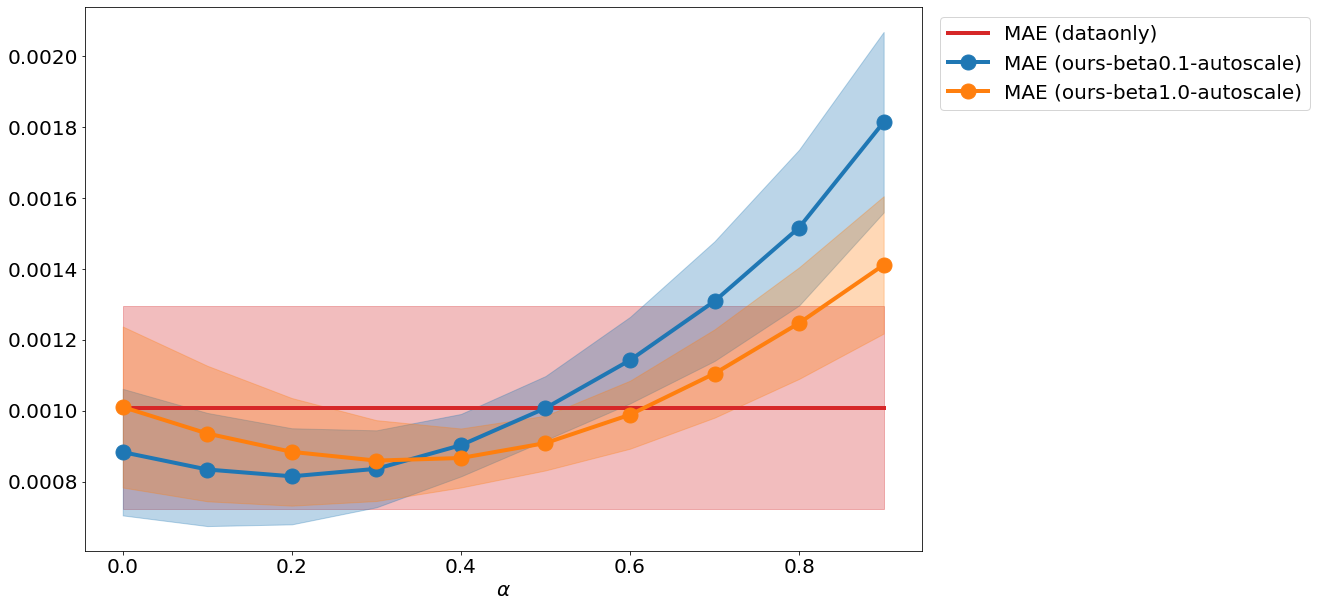

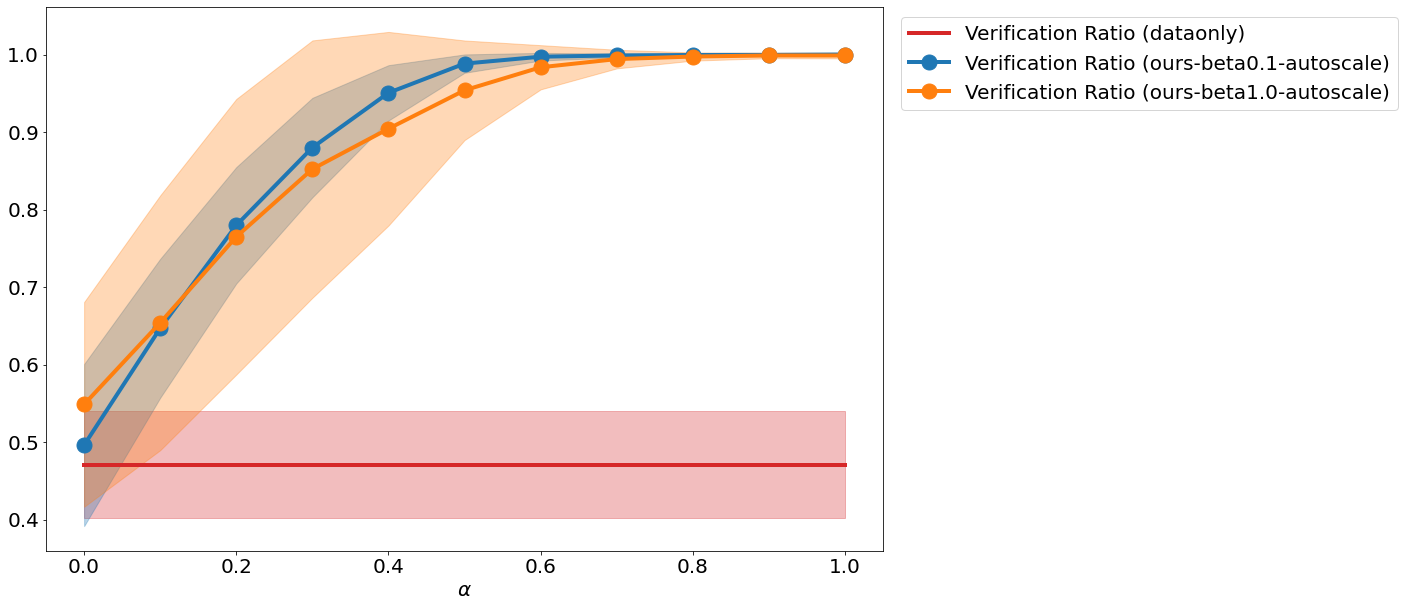

In [121]:
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20

for key, val in ret_dict.items():
    test_loss_list = []
    test_ratio_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
            test_loss_list.append(subval['test_loss'])
            test_ratio_list.append(subval['test_ratio'])
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)


# key_list = ['dataonly', 'ours-beta1', 'ours-fix-alpha0.5']
# key_list = ['dataonly', 'ours-beta0.1', 'ours-beta0.3', 'ours-beta0.5', 'ours-beta0.7', 'ours-beta0.9']
# key_list = ['dataonly', 'ours-beta0.1', 'ours-beta0.1-scale10', 'ours-beta0.1-scale100', 'ours-beta0.1-scale1000']
# key_list = ['dataonly', 'ours-beta1', 'ours-beta1.0-scale10', 'ours-beta1.0-scale100', 'ours-beta1.0-scale1000']
key_list = ['dataonly', 'ours-beta0.1-autoscale', 'ours-beta1.0-autoscale']
    
i, ii = 0, 10
plt.figure(0, figsize=(15,10))
# for j, (key, val) in enumerate(ret_dict.items()):
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
    plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    i += 1
    
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.ylim(0.0005, 0.003)


plt.figure(1, figsize=(15,10))
i = 0
# for j, (key, val) in enumerate(ret_dict.items()):
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
    plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
    i += 1

plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1), loc='upper left')

In [88]:
val['test_loss_avg']

array([0.00100913, 0.00100913, 0.00100913, 0.00100913, 0.00100913,
       0.00100913, 0.00100913, 0.00100913, 0.00100913, 0.00100913,
       0.00100913])

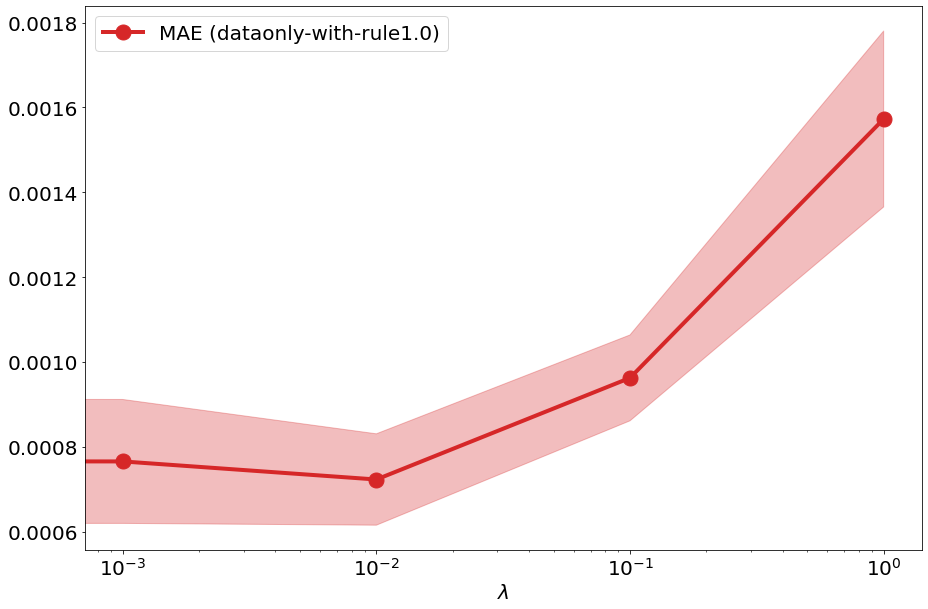

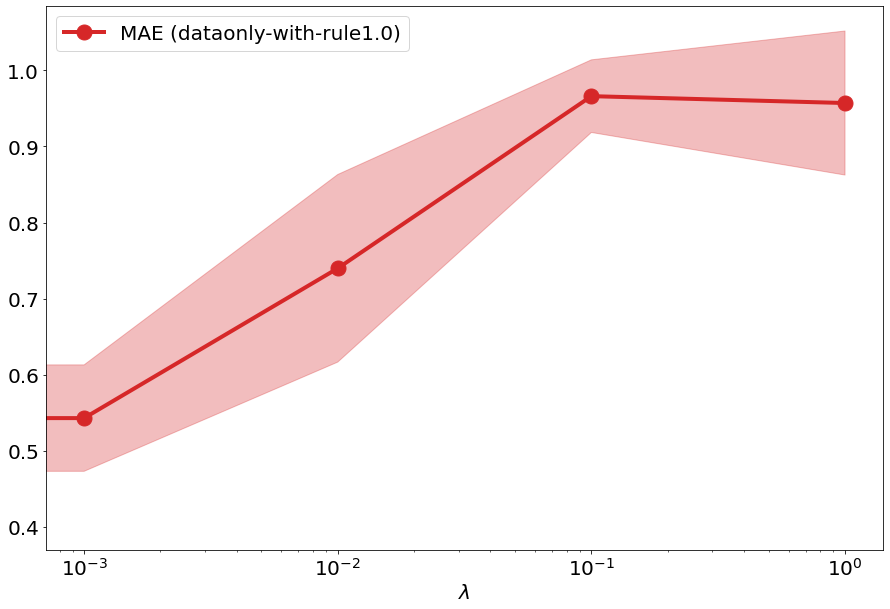

In [99]:
lambdas = [0., 0.001, 0.01, 0.1, 1.0]
key_list = ['dataonly', 'dataonly-with-rule0.001', 'dataonly-with-rule0.01', 'dataonly-with-rule0.1', 'dataonly-with-rule1.0']
    
plt.figure(0, figsize=(15,10))
with_rule_loss_avg = []
with_rule_loss_std = []
for key in key_list:
    val = ret_dict[key]
    with_rule_loss_avg.append(val['test_loss_avg'][0])
    with_rule_loss_std.append(val['test_loss_std'][0])
    
with_rule_loss_avg = np.array(with_rule_loss_avg)
with_rule_loss_std = np.array(with_rule_loss_std)
    
plt.plot(lambdas, with_rule_loss_avg, 'o-', color=colors[0], lw=4, ms=15, label='MAE')
plt.fill_between(lambdas, with_rule_loss_avg - with_rule_loss_std, with_rule_loss_avg + with_rule_loss_std, color=colors[0], alpha=0.3)
    
plt.xlabel(r'$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc='upper left')
plt.xscale('log', basex=10)


plt.figure(1, figsize=(15,10))
with_rule_ratio_avg = []
with_rule_ratio_std = []
for key in key_list:
    val = ret_dict[key]
    with_rule_ratio_avg.append(val['test_ratio_avg'][0])
    with_rule_ratio_std.append(val['test_ratio_std'][0])
    
with_rule_ratio_avg = np.array(with_rule_ratio_avg)
with_rule_ratio_std = np.array(with_rule_ratio_std)
    
plt.plot(lambdas, with_rule_ratio_avg, 'o-', color=colors[0], lw=4, ms=15, label='Verification Ratio')
plt.fill_between(lambdas, with_rule_ratio_avg - with_rule_ratio_std, with_rule_ratio_avg + with_rule_ratio_std, color=colors[0], alpha=0.3)

plt.xlabel(r'$\lambda$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc='upper left')
plt.xscale('log', basex=10)

## Analysis of results

In [14]:
from model import RuleEncoder, DataEncoder, Net, NaiveModel

rule_encoder = RuleEncoder(input_dim+static_input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim+static_input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model_eval = Net(output_dim_encoder*2, output_dim, rule_encoder, data_encoder, skip=SKIP).to(device)    # delta value prediction

# Skip connection
if from_data_only_model and model_type=='hybrid':
    if best_valid_loss == checkpoint['loss']:
        checkpoint = torch.load(trained_model_filename)
        print('loaded file: {}'.format(trained_model_filename))
    else:
        checkpoint = torch.load(saved_filename)
        print('loaded file: {}'.format(saved_filename))
else:
    checkpoint = torch.load(saved_filename)
    print('loaded file: {}'.format(saved_filename))
    
# checkpoint = torch.load(saved_filename)
# checkpoint = torch.load('saved_models/dp-data-only_0.3338_0.0_-1.9701_0.0-skip.demo.pt')

model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    target = test_y
    if static_input_dim:
        _test_x = torch.cat((static_X.repeat(test_x.shape[0],1), test_x), dim=1)
    else:
        _test_x = test_x
    if add_noise:
        _test_x += noise_scale*torch.randn(_test_x.shape, device=device)
    output = model_eval(_test_x, alpha=0.0, static_input_dim=static_input_dim, merge=merge)
    test_loss = l1_func(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))
print(model_type)

loaded file: saved_models/dp-hybrid_0.4886_0.0_0.4863_0.0-seed42.skip.demo.pt
best model loss: 0.009455	 at epoch: 80

Test set: Average loss: 0.00885735



Test set: Average loss: 0.00885735 (alpha:0.0)
ratio of verified predictions: 0.982222 (alpha:0.0)
Test set: Average loss: 0.00962424 (alpha:0.1)
ratio of verified predictions: 1.000000 (alpha:0.1)
Test set: Average loss: 0.01093174 (alpha:0.2)
ratio of verified predictions: 1.000000 (alpha:0.2)
Test set: Average loss: 0.01265191 (alpha:0.3)
ratio of verified predictions: 1.000000 (alpha:0.3)
Test set: Average loss: 0.01449247 (alpha:0.4)
ratio of verified predictions: 1.000000 (alpha:0.4)
Test set: Average loss: 0.01642808 (alpha:0.5)
ratio of verified predictions: 1.000000 (alpha:0.5)
Test set: Average loss: 0.01848025 (alpha:0.6)
ratio of verified predictions: 1.000000 (alpha:0.6)
Test set: Average loss: 0.02074639 (alpha:0.7)
ratio of verified predictions: 1.000000 (alpha:0.7)
Test set: Average loss: 0.02322583 (alpha:0.8)
ratio of verified predictions: 1.000000 (alpha:0.8)
Test set: Average loss: 0.02584677 (alpha:0.9)
ratio of verified predictions: 1.000000 (alpha:0.9)
Test set: 

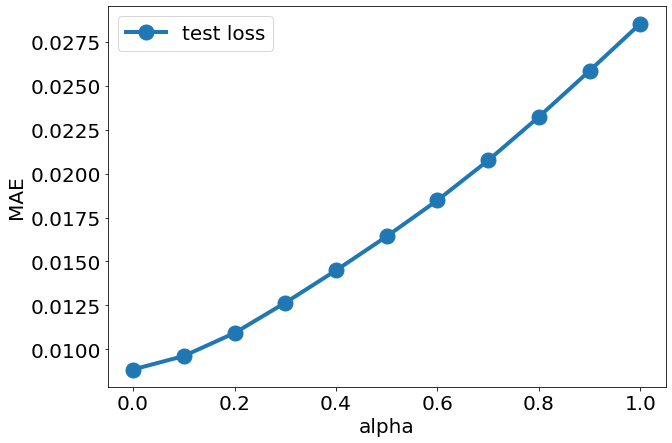

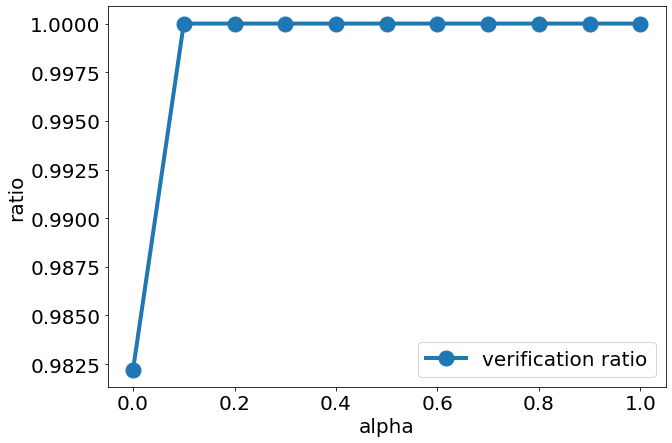

In [16]:
model = model_eval

test_loss_alpha = []
test_ratio_alpha = []


alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for _alpha in alphas:
    model.eval()

    with torch.no_grad():
        if static_input_dim:
            input_data = torch.cat((static_X.repeat(test_x.shape[0],1), test_x), dim=1)
        else:
            input_data = test_x
#         if add_noise:
#             input_data += noise_scale*torch.randn(input_data.shape, device=device)
        target_data = test_y

        if model_type == 'dataonly':
            output = model(input_data, alpha=0.0, static_input_dim=static_input_dim, merge=merge)
        elif model_type == 'hybrid':
            output = model(input_data, alpha=_alpha, static_input_dim=static_input_dim, merge=merge)
        elif model_type == 'rule-only':
            output = model(input_data, alpha=1.0, static_input_dim=static_input_dim, merge=merge)
        
        test_loss = l1_func(output, target_data).item()  # sum up batch loss
        
        _, _, curr_E = calc_double_E(input_data[:,static_input_dim:], **dp_params)
        _, _, next_E = calc_double_E(target_data, **dp_params)
        _, _, pred_E = calc_double_E(output, **dp_params)
        
        test_ratio = verification(curr_E, pred_E, threshold=0.0).item()

    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss, _alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, _alpha))
    
    test_loss_alpha.append(test_loss)
    test_ratio_alpha.append(test_ratio)

print()
for test_loss in test_loss_alpha:
    print("{:.6f}".format(test_loss))
print()
for test_ratio in test_ratio_alpha:
    print("{:.6f}".format(test_ratio))

    
plt.figure(0, figsize=(10,7))
plt.plot(alphas, test_loss_alpha, 'o-', lw=4, markersize=15, label='test loss')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(alphas, test_ratio_alpha, 'o-', lw=4, markersize=15, label='verification ratio')
plt.xlabel('alpha', fontsize=20)
plt.ylabel('ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)

In [133]:
# ret_dict_seed43 = ret_dict
# ret_dict_seed41 = ret_dict

In [234]:
# ret_dict = {}
ret_dict['test_loss_data_only'] = test_loss_alpha
ret_dict['test_ratio_data_only'] = test_ratio_alpha
# ret_dict['test_loss_hybrid'] = test_loss_alpha
# ret_dict['test_ratio_hybrid'] = test_ratio_alpha

In [170]:
# ret_dict = ret_dict_seed41
ret_dict 

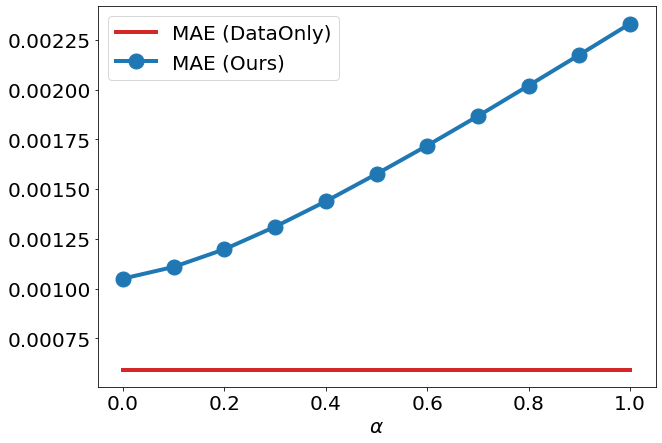

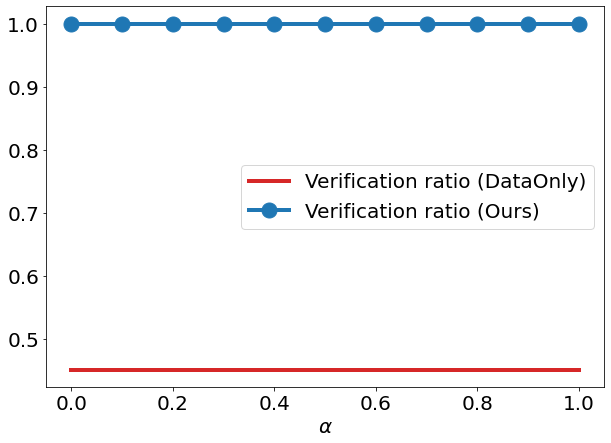

In [171]:
plt.figure(0, figsize=(10,7))
plt.plot(alphas, ret_dict['test_loss_data_only'][:1]*len(alphas), '-', color='tab:red', lw=4, label=r'MAE (DataOnly)')
plt.plot(alphas, ret_dict['test_loss_hybrid'], 'o-', color='tab:blue', lw=4, markersize=15, label=r'MAE (Ours)')
plt.xlabel(r'$\alpha$', fontsize=20)
# plt.ylabel('MAE', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# plt.savefig('img/mae-two-models_0.3338_0.0_-1.9701_0.0-skip.pdf', bbox_inches='tight')

plt.figure(1, figsize=(10,7))
plt.plot(alphas, ret_dict['test_ratio_data_only'][:1]*len(alphas), '-', color='tab:red', lw=4, label='Verification ratio (DataOnly)')
plt.plot(alphas, ret_dict['test_ratio_hybrid'], 'o-', color='tab:blue', lw=4, markersize=15, label='Verification ratio (Ours)')
plt.xlabel(r'$\alpha$', fontsize=20)
# plt.ylabel('Verification ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

# plt.savefig('img/verification-two-models_0.3338_0.0_-1.9701_0.0-skip.pdf', bbox_inches='tight')

In [235]:
seed

44

In [236]:
ret_dict_seed44 = dict(ret_dict)

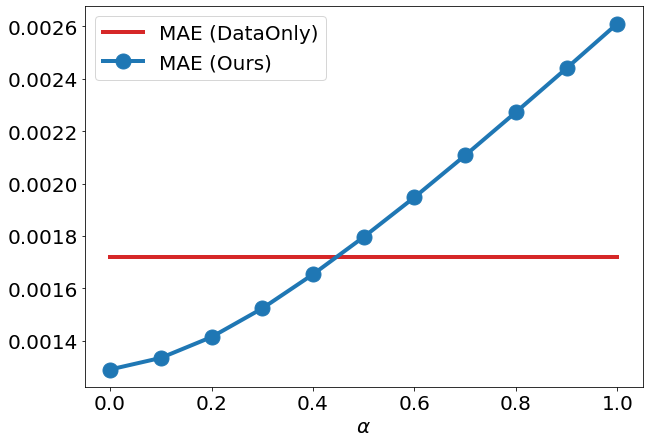

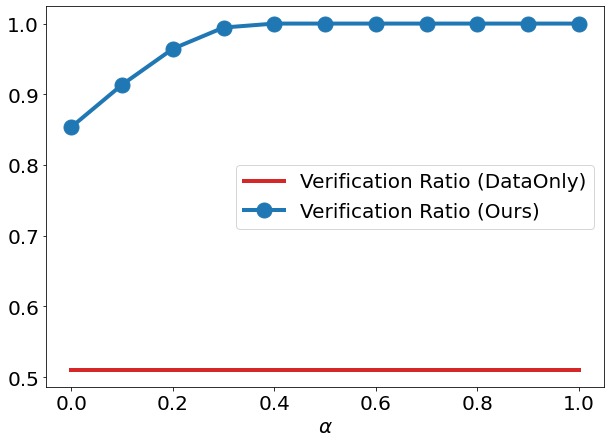

In [237]:
test_loss_dataonly = np.array([ret_dict_seed44['test_loss_data_only'],
                               ret_dict_seed43['test_loss_data_only'],
                               ret_dict_seed41['test_loss_data_only'],
                               ret_dict_seed40['test_loss_data_only']])

test_loss_ours = np.array([ret_dict_seed44['test_loss_hybrid'],
                           ret_dict_seed43['test_loss_hybrid'],
                           ret_dict_seed41['test_loss_hybrid'],
                           ret_dict_seed40['test_loss_hybrid']])

test_ratio_dataonly = np.array([ret_dict_seed44['test_ratio_data_only'],
                                ret_dict_seed43['test_ratio_data_only'],
                                ret_dict_seed41['test_ratio_data_only'],
                                ret_dict_seed40['test_ratio_data_only']])

test_ratio_ours = np.array([ret_dict_seed44['test_ratio_hybrid'],
                            ret_dict_seed43['test_ratio_hybrid'],
                            ret_dict_seed41['test_ratio_hybrid'],
                            ret_dict_seed40['test_ratio_hybrid']])


plt.figure(0, figsize=(10,7))
plt.plot(alphas, np.mean(test_loss_dataonly, 0), '-', color='tab:red', lw=4, label='MAE (DataOnly)')
plt.plot(alphas, np.mean(test_loss_ours, 0), 'o-', color='tab:blue', lw=4, markersize=15, label='MAE (Ours)')
# plt.errorbar(alphas, np.mean(test_loss_dataonly, 0), yerr=np.std(test_loss_dataonly, axis=0), color='tab:red', lw=4, label='MAE (DataOnly)')
# plt.errorbar(alphas, np.mean(test_loss_ours, 0), yerr=np.std(test_loss_ours, axis=0), color='tab:blue', lw=4, markersize=15, label='MAE (Ours)')
plt.xlabel(r'$\alpha$', fontsize=20)
# plt.ylabel('Verification ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)


plt.figure(1, figsize=(10,7))
plt.plot(alphas, np.mean(test_ratio_dataonly, 0), '-', color='tab:red', lw=4, label='Verification Ratio (DataOnly)')
plt.plot(alphas, np.mean(test_ratio_ours, 0), 'o-', color='tab:blue', lw=4, markersize=15, label='Verification Ratio (Ours)')
plt.xlabel(r'$\alpha$', fontsize=20)
# plt.ylabel('Verification ratio', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)


In [220]:
test_loss_ours

array([[0.00125541, 0.00122538, 0.00124333, 0.00130218, 0.00139479,
        0.00150659, 0.00162789, 0.00175298, 0.00188098, 0.00201131,
        0.00214312],
       [0.00104969, 0.00110856, 0.00119716, 0.00131076, 0.0014385 ,
        0.00157605, 0.00171884, 0.00186716, 0.00202066, 0.00217523,
        0.00233202],
       [0.00207705, 0.0021345 , 0.002222  , 0.00233082, 0.00245869,
        0.00260026, 0.00275673, 0.00292389, 0.00309755, 0.0032768 ,
        0.00345921]])

In [77]:
'''
Visualize examples violating a rule
'''
rule_encoder = RuleEncoder(input_dim+static_input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim+static_input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model_eval = Net(output_dim_encoder*2, output_dim, rule_encoder, data_encoder, skip=SKIP).to(device)    # delta value prediction

# checkpoint = torch.load('saved_models/dp-data-only_0.3338_0.0_-1.9701_0.0-skip.demo.pt')
# checkpoint = torch.load('saved_models/dp-hybrid_0.3338_0.0_-1.9701_0.0-skip.demo.pt')

if from_data_only_model and model_type=='hybrid':
    if best_valid_loss == checkpoint['loss']:
        checkpoint = torch.load(trained_model_filename)
        print('loaded file: {}'.format(trained_model_filename))
    else:
        checkpoint = torch.load(saved_filename)
        print('loaded file: {}'.format(saved_filename))
else:
    checkpoint = torch.load(saved_filename)
    print('loaded file: {}'.format(saved_filename))
    
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))


model = model_eval
model.eval()

with torch.no_grad():
    input_data = torch.cat((static_X.repeat(test_x.shape[0],1), test_x), dim=1)
    target_data = test_y

    if model_type == 'data-only':
        output = model(input_data, alpha=0.0, static_input_dim=static_input_dim)
    elif model_type == 'hybrid':
        output = model(input_data, alpha=0.9, static_input_dim=static_input_dim)

    _, _, curr_E = calc_double_E(input_data[:,static_input_dim:], **dp_params)
    _, _, next_E = calc_double_E(target_data, **dp_params)
    _, _, pred_E = calc_double_E(output, **dp_params)

test_ratio = verification(curr_E, pred_E, threshold=0.0).item()


loaded file: saved_models/dp-hybrid_-0.1102_0.0_-0.0845_0.0-skip.demo.pt
best model loss: 0.000175	 at epoch: 5


In [18]:
next_E

tensor([1.1947, 1.1946, 1.1946,  ..., 0.9080, 0.9080, 0.9080], device='cuda:0')

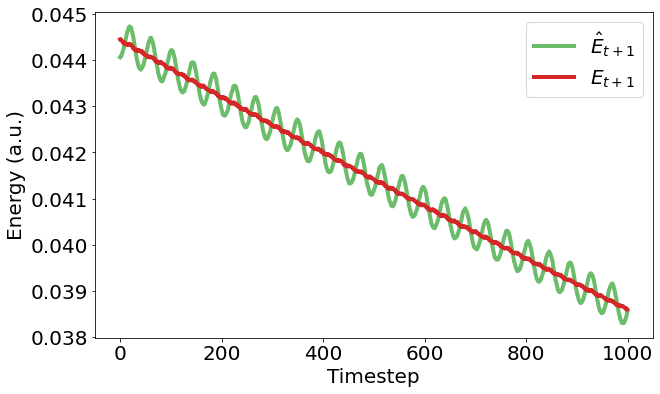

In [78]:
import matplotlib as mpl

# mpl.style.use('default')

fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(curr_E.cpu().numpy()[:1000], '-', color='tab:blue', lw=4, ms=10, alpha=1.0, label=r'$E_t$')
ax.plot(pred_E.cpu().numpy()[:1000], '-', color='tab:green', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')
ax.plot(next_E.cpu().numpy()[:1000], '-', color='tab:red', lw=4, ms=10, alpha=1.0, label=r'$E_{t+1}$')

plt.xlabel('Timestep', fontsize=20)
plt.ylabel('Energy (a.u.)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20)

# plt.savefig('img/dp-data-only.pdf', bbox_inches='tight')
# plt.savefig('img/dp-hybrid.pdf', bbox_inches='tight')

In [184]:
3+4

7


Test set: Average loss: 0.00439565



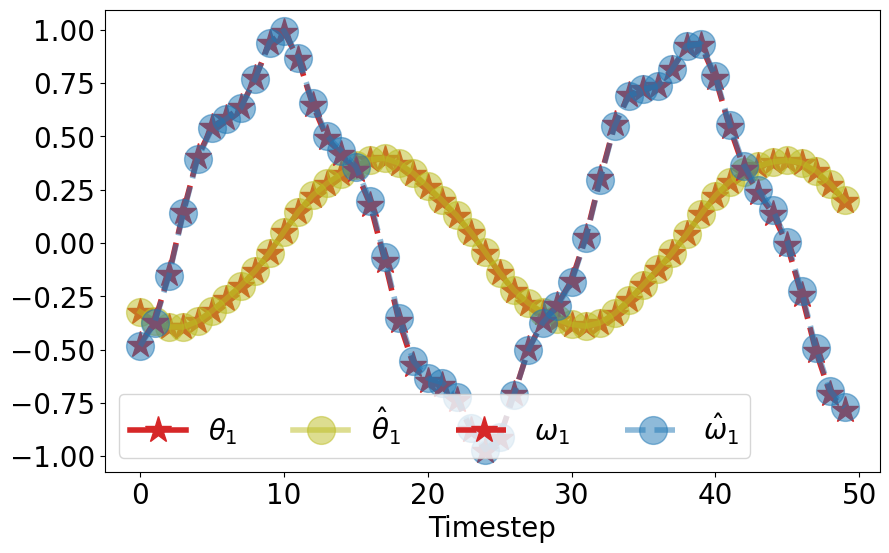

In [211]:
# Test
model = model_eval
# model = model_data_only
# model = NaiveModel()

model.eval()
test_loss = 0
with torch.no_grad():
    target = test_y
    output = model(test_x, alpha=0.0)
    test_loss = loss_task(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

max_ind = 50
plt.figure(0, figsize=(10,6))
plt.plot(target.cpu()[:max_ind,0], '*-', color='tab:red', lw=4, ms=20, alpha=1.0, label=r'$\theta_1$')
plt.plot(output.cpu()[:max_ind,0], 'o-', color='tab:olive', lw=4, ms=20, alpha=0.5, label=r'$\hat{\theta}_1$')
plt.plot(target.cpu()[:max_ind,1], '*--', color='tab:red', lw=4, ms=20, alpha=1.0, label=r'$\omega_1$')
plt.plot(output.cpu()[:max_ind,1], 'o--', color='tab:blue', lw=4, ms=20, alpha=0.5, label=r'$\hat{\omega}_1$')
plt.xlabel('Timestep', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20, ncol=4)

# plt.figure(1, figsize=(15,9))
# plt.plot(target.cpu()[:max_ind,2], '^-', lw=4, ms=10, alpha=1.0, label=r'$\theta_2$')
# plt.plot(output.cpu()[:max_ind,2], '^-', lw=4, ms=10, alpha=1.0, label=r'$\hat{\theta}_2$')
# plt.plot(target.cpu()[:max_ind,3], '*--', lw=4, ms=10, alpha=1.0, label=r'$\omega_2$')
# plt.plot(output.cpu()[:max_ind,3], '*--', lw=4, ms=10, alpha=1.0, label=r'$\hat{\omega}_2$')
# plt.xlabel('Timestep (s)', fontsize=20)
# plt.xticks(fontsize=20)
# # plt.yticks(fontsize=20)
# plt.yticks([])
# plt.legend(fontsize=20)

# _, _, pred_E = calc_double_E(output, **dp_params)

# loss_task(target.cpu()[:,0], output.cpu()[:,0])
# loss_task(target.cpu()[:,1], output.cpu()[:,1])
# loss_task(target.cpu()[:,2], output.cpu()[:,2])
# loss_task(target.cpu()[:,3], output.cpu()[:,3])


plt.savefig('img/dp-data-only_prediction.pdf', bbox_inches='tight') 